##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

### Import and configure modules

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Define a function to load an image and limit its maximum dimension to 512 pixels.

def load_img(path_to_img):
  max_dim = 256
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

  # Create a simple function to display an image:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}



TensorFlow 2.x selected.


80142336/80134624 [==============================] - 2s 0us/step


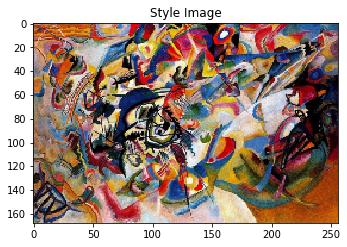

In [ ]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# content_path = '/content/floating elephant with humans.jpg'
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
# https://commons.wikimedia.org/wiki/File:Paul_Gauguin_044.jpg
# style_path = tf.keras.utils.get_file('floating elephant with humans.jpg','https://drive.google.com/uc?export=download&id=1xYF_l9KSCOvGbRQzMm7vNrM4-Be24xuO')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
# content_image = load_img(content_path)
style_image = load_img(style_path)

# plt.subplot(1, 2, 1)
# imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-1
content_weight=1e3
total_variation_weight=30

In [ ]:
file_name = 'stylized-image2.png'
tensor_to_image(sample_img[5]).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()

def TransformNet(input_shape = (256, 256, 3)):

    # Define the input as a tensor with shape input_shape
    X_input = tf.keras.Input(input_shape)

    X = convolutional_block(X_input, 5, 32, 1)
    X = convolutional_block(X, 3, 64, 2)
    X = convolutional_block(X, 3, 128, 2)

    X = residual_block(X, 3)
    X = residual_block(X, 3)
    X = residual_block(X, 3)
    X = residual_block(X, 3)
    X = residual_block(X, 3)

    X = convolutional_tranpose_block(X, 3, 64, 2)
    X = convolutional_tranpose_block(X, 3, 32, 2)
    # X = convolutional_block(X, 9, 3, 1, relu=False)
    X = layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='tanh')(X)
    # X = layers.Activation('tanh')(X)
    # X = X * 150 + 255./2
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name='TransformNet')

    return model

def convolutional_tranpose_block(X, f, filters, strides):

    X = layers.Conv2DTranspose(filters=filters, kernel_size=(f, f), strides=(strides, strides), padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU()(X)

    return X

def convolutional_block(X, f, filters, strides, relu=True):

    X = layers.Conv2D(filters=filters, kernel_size=(f, f), strides=(strides, strides), padding='same')(X)
    X = layers.BatchNormalization()(X)
    if relu:
      X = layers.LeakyReLU()(X)

    return X

def residual_block(X, f):

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####

    # First component of main path
    X = layers.Conv2D(filters=128, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU()(X)

    # Second component of main path
    X = layers.Conv2D(filters=128, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization()(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = layers.Add()([X, X_shortcut])
    # X = layers.LeakyReLU()(X)

    return X

In [ ]:
# del generator
generator = TransformNet()
# generator.summary()


In [ ]:
# generator.save('/content/drive/My Drive/training_checkpoints/model1.h5')
# del generator
# generator = tf.keras.models.load_model('/content/drive/My Drive/training_checkpoints/model1.h5')
# # generator.compile()

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# content_path = '/content/drive/My Drive/data_colab/cat.jpeg'
content_image = load_img(content_path)
# content_image = preprocess_image_train(content_image)
# generate_images(generator, style_image)
# sample_img.shape

In [ ]:
def generate_images(model, test_input, epoch=0):
  prediction = model(test_input, training=False)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0]/255, prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.axis('off')
  plt.show()

In [ ]:
import os
checkpoint_dir = './training_checkpoints/kandinsky2/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
backup_ckpt =  os.path.join("/content/drive/My Drive/training_checkpoints/model2", "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=opt, model=generator)

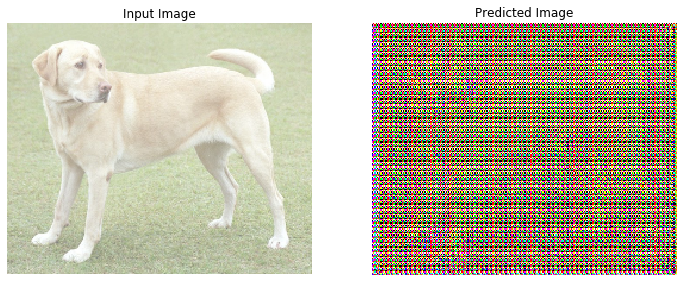

In [ ]:
# plt.imshow(content_image)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

generate_images(generator, content_image*255)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
@tf.function()
def train_step(images):
  with tf.GradientTape() as tape:
    generated_images = generator(images, training=True)
    outputs = extractor(generated_images)
    content_targets = extractor(images)['content']
    loss = style_content_loss(outputs, style_targets, content_targets)
    loss += total_variation_weight*tf.image.total_variation(generated_images)

  grad = tape.gradient(loss, generator.trainable_variables)
  opt.apply_gradients(zip(grad, generator.trainable_variables))
  # images.assign(clip_0_1(generated_images))


In [ ]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'


13510574080/13510573713 [==============================] - 771s 0us/step


In [ ]:

!rm -rf  '/content/training_checkpoints/kandinsky2'*
# !cp /content/training_checkpoints/kandinsky/ckpt-343.* '/content/drive/My Drive/training_checkpoints/'
# print(PATH)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# image_datagen = ImageDataGenerator(rescale=1./255)
image_datagen = ImageDataGenerator()

train_data = image_datagen.flow_from_directory(
    directory='/content/',
    target_size=(256, 256),
    batch_size=16,
    class_mode=None,
    shuffle=True,
    seed=42
)
sample_img = next(iter(train_data))

Found 82849 images belonging to 7 classes.


In [ ]:
# generator.save('/content/drive/My Drive/training_checkpoints/model3.h5')
generator = tf.keras.models.load_model('/content/drive/My Drive/training_checkpoints/model2.h5')


In [ ]:
import time
from keras import backend as K
epochs = 100
# def train(train_data, epochs):
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
start = time.time()
step = 0
for n in range(epochs):
  for _, images in zip(range(1000), train_data):
    train_step(images)
    print(".", end='')
    if (step + 1) % 200 == 0:
    # Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_images(generator, content_image*255)
      # Save the model weights every x steps
      checkpoint.save(file_prefix = checkpoint_prefix)
  # tf.saved_model.save(extractor, checkpoint_dir)
    step +=1
  print("Train step: {}".format(step))
  checkpoint.save(file_prefix = backup_ckpt)
end = time.time()
print("Total time: {:.1f}".format(end-start))


Using TensorFlow backend.


NameError: ignored

In [ ]:
train_data.image_shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


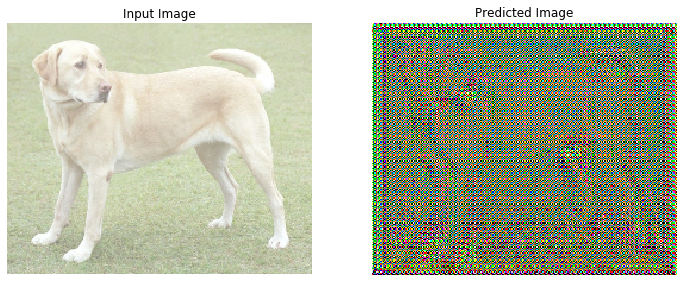

In [ ]:
# import tensorflow as tf
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_img(content_path)
checkpoint_dir = '/content/drive/My Drive/training_checkpoints/model2/'
# generator.save('/content/drive/My Drive/training_checkpoints/model4.h5')
del new_model
new_model = tf.keras.models.load_model('/content/drive/My Drive/training_checkpoints/model2.h5')
checkpoint = tf.train.Checkpoint()
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
generate_images(new_model, content_image*255)